# Load Python Modules

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import numpy as np
import pandas as pd
import shutil
import deepchem as dc
import json

from rdkit import Chem
from sklearn.metrics import roc_auc_score
from  sklearn.neighbors import KNeighborsClassifier
from tqdm import tnrange, tqdm_notebook

/pylon5/ac5616p/yuke/anaconda3/envs/MolEnv2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
os.chdir('/home/yuke/PythonProject/DrugEmbedding/')
from decode import *

In [4]:
"""
SIDER dataset loader.
"""
def load_sider(featurizer='ECFP', split='index', seed=0):
    #current_dir = os.path.dirname(os.path.realpath(__file__))

    # Load SIDER dataset
    print("About to load SIDER dataset.")
    dataset_file = os.path.join("./data/sider/deepchem/sider.csv.gz")
    dataset = dc.utils.save.load_from_disk(dataset_file)
    print("Columns of dataset: %s" % str(dataset.columns.values))
    print("Number of examples in dataset: %s" % str(dataset.shape[0]))

    # Featurize SIDER dataset
    print("About to featurize SIDER dataset.")
    if featurizer == 'ECFP':
        featurizer = dc.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
        featurizer = dc.feat.ConvMolFeaturizer()

    SIDER_tasks = dataset.columns.values[1:].tolist()
    print("SIDER tasks: %s" % str(SIDER_tasks))
    print("%d tasks in total" % len(SIDER_tasks))

    loader = dc.data.CSVLoader(
      tasks=SIDER_tasks, smiles_field="smiles", featurizer=featurizer)
    dataset = loader.featurize(dataset_file)
    print("%d datapoints in SIDER dataset" % len(dataset))

    # Initialize transformers
    transformers = [
      dc.trans.BalancingTransformer(transform_w=True, dataset=dataset)]
    print("About to transform data")
    for transformer in transformers:
        dataset = transformer.transform(dataset)

    splitters = {'index': dc.splits.IndexSplitter(),
               'random': dc.splits.RandomSplitter(),
               'scaffold': dc.splits.ScaffoldSplitter()}
    splitter = splitters[split]
    train, valid, test = splitter.train_valid_test_split(dataset, seed=seed)

    return SIDER_tasks, (train, valid, test), transformers

# Load Model

In [5]:
seed = 94
#np.random.seed(seed)

In [6]:
exp_dir = './experiments/KDD/kdd_010'
checkpoint = 'checkpoint_epoch110.model'
config_path = os.path.join(exp_dir, 'configs.json')
checkpoint_path = os.path.join(exp_dir, checkpoint)

with open(config_path, 'r') as fp:
    configs = json.load(fp)
fp.close()

configs['checkpoint'] = checkpoint
configs

{'data_dir': './data/fda_drugs',
 'data_file': 'smiles_set_clean.smi',
 'fda_file': 'all_drugs.smi',
 'vocab_file': 'char_set_clean.pkl',
 'atc_sim_file': 'drugs_sp_all.csv',
 'checkpoint_dir': './experiments/KDD',
 'experiment_name': 'kdd_010',
 'task': 'vae + atc',
 'limit': 0,
 'batch_size': 128,
 'epochs': 100,
 'max_sequence_length': 120,
 'learning_rate': 0.0003,
 'max_norm': 1000000000000.0,
 'wd': 0.0,
 'manifold_type': 'Lorentz',
 'prior_type': 'Standard',
 'num_centroids': 0,
 'bidirectional': False,
 'num_layers': 1,
 'hidden_size': 512,
 'latent_size': 64,
 'word_dropout_rate': 0.2,
 'anneal_function': 'logistic',
 'k': 0.51,
 'x0': 29.0,
 'C': 1.0,
 'num_workers': 4,
 'logging_steps': 1,
 'save_per_epochs': 10,
 'new_training': False,
 'new_annealing': False,
 'checkpoint': 'checkpoint_epoch110.model',
 'trained_epochs': 110,
 'alpha': 0.0,
 'beta': 0.015625,
 'gamma': 0.0,
 'delta': 11.0,
 'nneg': 11,
 'fda_prop': 0.2}

In [7]:
model = load_model(configs)
print(model)

HVAE(
  (encoder_rnn): GRU(49, 512, batch_first=True)
  (decoder_rnn): GRU(49, 512, batch_first=True)
  (hidden2mean): Linear(in_features=512, out_features=64, bias=True)
  (hidden2logv): Linear(in_features=512, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=65, out_features=512, bias=True)
  (outputs2vocab): Linear(in_features=512, out_features=49, bias=True)
  (RECON): NLLLoss()
)


In [8]:
exp_dir = './experiments/KDD/kdd_009'
checkpoint = 'checkpoint_epoch110.model'
config_path = os.path.join(exp_dir, 'configs.json')
checkpoint_path = os.path.join(exp_dir, checkpoint)

with open(config_path, 'r') as fp:
    configs_e = json.load(fp)
fp.close()

configs_e['checkpoint'] = checkpoint
configs_e

{'data_dir': './data/fda_drugs',
 'data_file': 'smiles_set_clean.smi',
 'fda_file': 'all_drugs.smi',
 'vocab_file': 'char_set_clean.pkl',
 'atc_sim_file': 'drugs_sp_all.csv',
 'checkpoint_dir': './experiments/KDD',
 'experiment_name': 'kdd_009',
 'task': 'vae + atc',
 'limit': 0,
 'batch_size': 128,
 'epochs': 100,
 'max_sequence_length': 120,
 'learning_rate': 0.0003,
 'max_norm': 1000000000000.0,
 'wd': 0.0,
 'manifold_type': 'Euclidean',
 'prior_type': 'Standard',
 'num_centroids': 0,
 'bidirectional': False,
 'num_layers': 1,
 'hidden_size': 512,
 'latent_size': 64,
 'word_dropout_rate': 0.2,
 'anneal_function': 'logistic',
 'k': 0.51,
 'x0': 29.0,
 'C': 1.0,
 'num_workers': 4,
 'logging_steps': 1,
 'save_per_epochs': 10,
 'new_training': False,
 'new_annealing': False,
 'checkpoint': 'checkpoint_epoch110.model',
 'trained_epochs': 110,
 'alpha': 0.0,
 'beta': 0.015625,
 'gamma': 0.0,
 'delta': 11.0,
 'nneg': 11,
 'fda_prop': 0.2}

In [9]:
model_e = load_model(configs_e)
print(model_e)

EVAE(
  (encoder_rnn): GRU(49, 512, batch_first=True)
  (decoder_rnn): GRU(49, 512, batch_first=True)
  (hidden2mean): Linear(in_features=512, out_features=64, bias=True)
  (hidden2logv): Linear(in_features=512, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=512, bias=True)
  (outputs2vocab): Linear(in_features=512, out_features=49, bias=True)
  (RECON): NLLLoss()
)


# Process Data

In [10]:
sider_tasks, datasets, transformers = load_sider(split='random', seed=seed)
train_dataset, valid_dataset, test_dataset = datasets

About to load SIDER dataset.
Columns of dataset: ['smiles' 'Hepatobiliary disorders' 'Metabolism and nutrition disorders'
 'Product issues' 'Eye disorders' 'Investigations'
 'Musculoskeletal and connective tissue disorders'
 'Gastrointestinal disorders' 'Social circumstances'
 'Immune system disorders' 'Reproductive system and breast disorders'
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)'
 'General disorders and administration site conditions'
 'Endocrine disorders' 'Surgical and medical procedures'
 'Vascular disorders' 'Blood and lymphatic system disorders'
 'Skin and subcutaneous tissue disorders'
 'Congenital, familial and genetic disorders'
 'Infections and infestations'
 'Respiratory, thoracic and mediastinal disorders' 'Psychiatric disorders'
 'Renal and urinary disorders'
 'Pregnancy, puerperium and perinatal conditions'
 'Ear and labyrinth disorders' 'Cardiac disorders'
 'Nervous system disorders'
 'Injury, poisoning and procedural complications']
Num

In [11]:
# side effects labels
train_y = train_dataset.y
valid_y = valid_dataset.y
test_y = test_dataset.y

In [12]:
# Finger Print
train_fp = train_dataset.X
valid_fp = valid_dataset.X
test_fp = test_dataset.X

In [13]:
train_smi = train_dataset.ids
valid_smi = valid_dataset.ids
test_smi = test_dataset.ids

In [14]:
def smi2mean(configs, model, smi_lst):
    mean_lst = []
    for i in tnrange(len(smi_lst)):
        # convert to canonical form
        smi = smi_lst[i]
        try:
            smi_can = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        except:
            smi_can = smi
        mean, _ = smiles2mean(configs, smi_can, model)
        mean_lst.append(mean.squeeze().cpu().detach().numpy())
    return np.array(mean_lst)

In [15]:
train_mu = smi2mean(configs, model, train_smi)

In [16]:
valid_mu = smi2mean(configs, model, valid_smi)

In [17]:
test_mu = smi2mean(configs, model, test_smi)

In [18]:
train_mu_e = smi2mean(configs_e, model_e, train_smi)

In [19]:
valid_mu_e = smi2mean(configs_e, model_e, valid_smi)

In [20]:
test_mu_e = smi2mean(configs_e, model_e, test_smi)

# Custom Distance Functions

In [21]:
def lor_dist(z1, z2):
    m = z1*z2
    lor_prod = m[1:].sum() - m[0]
    x = - lor_prod
    x = np.where(x<1.0, 1.0+1e-6, x)
    return np.log(x + np.sqrt(x**2 - 1))

# KNN Classifier

In [22]:
def get_scores(y_true, y_pred):
    roc_aucs = []
    n_data, n_dim = y_true.shape
    for j in range(n_dim):
        true_label = y_true[:, j]
        pred_label = y_pred[:, j]
        roc_aucs.append(roc_auc_score(true_label, pred_label))
    return np.array(roc_aucs)

## Hyperparameters

In [23]:
# pick N and weights type based on validation dataset
#N = np.arange(3, 31, 2)
#W = ['uniform', 'distance']

#roc_scores = np.zeros((len(N), len(W)))
#for i in tnrange(len(N)):
#    n = N[i]
#    for j in range(len(W)):
#        w = W[j]
#        neigh = KNeighborsClassifier(n_neighbors=n, algorithm='brute', metric=lor_dist, weights=w)
#        neigh.fit(train_mu, train_y)
#        
#        pred = neigh.predict_proba(valid_mu) # 27 * size(x) * 2
#        # covert predicted probability to an array
#        n_data, n_dim = valid_y.shape
#        valid_y_pred = np.zeros((n_data, n_dim))
#        for jj in range(n_dim):
#            valid_y_pred[:, jj] = pred[jj][:, 1]
#        roc_scores[i,j] = get_scores(valid_y, valid_y_pred).mean()

In [24]:
#roc_scores

In [25]:
#ind = np.unravel_index(np.argmax(roc_scores, axis=None), roc_scores.shape)
#N_val = N[ind[0]]
#W_val = W[ind[1]]

In [26]:
N_val = 11
W_val = 'distance'

## Fit and Predict

### Finger Prints

In [859]:
# Finger Print Representations
neigh_fp = KNeighborsClassifier(n_neighbors=N_val, algorithm='brute', metric='rogerstanimoto', weights=W_val)
neigh_fp.fit(train_fp, train_y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='rogerstanimoto',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [860]:
pred_fp = neigh_fp.predict_proba(test_fp) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_pred_fp = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_pred_fp[:, j] = pred_fp[j][:, 1]
    
#test_y_pred_fp = neigh_fp.predict(test_fp)

### Lorentz Embeddings

In [861]:
neigh_lor = KNeighborsClassifier(n_neighbors=N_val, algorithm='brute', metric=lor_dist, weights=W_val)
neigh_lor.fit(train_mu, train_y)

KNeighborsClassifier(algorithm='brute', leaf_size=30,
                     metric=<function lor_dist at 0x7f453e581048>,
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [862]:
pred_lor = neigh_lor.predict_proba(test_mu) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_pred_lor = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_pred_lor[:, j] = pred_lor[j][:, 1]    
#test_y_pred_lor = neigh_lor.predict(test_mu)

### Euclidean Embeddings

In [863]:
neigh_euc = KNeighborsClassifier(n_neighbors=N_val, algorithm='brute', weights=W_val)
neigh_euc.fit(train_mu_e, train_y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [864]:
pred_euc = neigh_euc.predict_proba(test_mu_e) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_pred_euc = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_pred_euc[:, j] = pred_euc[j][:, 1]    
#test_y_pred_lor = neigh_lor.predict(test_mu)

## Evaluation

In [865]:
get_scores(test_y, test_y_pred_fp).mean()

0.6458398619647381

In [866]:
get_scores(test_y, test_y_pred_lor).mean()

0.6918879079609296

In [867]:
get_scores(test_y, test_y_pred_euc).mean()

0.7212944949110265

# RF

## Finger Print

In [868]:
rf_fp = RandomForestClassifier(class_weight="balanced", n_estimators=500)
rf_fp.fit(train_fp, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [869]:
rf_pred_fp = rf_fp.predict_proba(test_fp) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_rf_pred_fp = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_rf_pred_fp[:, j] = rf_pred_fp[j][:, 1]    
#test_y_pred_lor = neigh_lor.predict(test_mu)

In [870]:
get_scores(test_y, test_y_rf_pred_fp).mean()

0.6956212473853256

## Lorentz Embeddings

In [871]:
rf_lor = RandomForestClassifier(class_weight="balanced", n_estimators=500)
rf_lor.fit(train_mu, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [872]:
rf_pred_lor = rf_lor.predict_proba(test_mu) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_rf_pred_lor = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_rf_pred_lor[:, j] = rf_pred_lor[j][:, 1]    
#test_y_pred_lor = neigh_lor.predict(test_mu)

In [873]:
get_scores(test_y, test_y_rf_pred_lor).mean()

0.6962457163532647

## Euclidean Embeddings

In [874]:
rf_euc = RandomForestClassifier(class_weight="balanced", n_estimators=500)
rf_euc.fit(train_mu_e, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [875]:
rf_pred_euc = rf_euc.predict_proba(test_mu_e) # 27 * size(x) * 2

# covert predicted probability to an array
n_data, n_dim = test_y.shape
test_y_rf_pred_euc = np.zeros((n_data, n_dim))
for j in range(n_dim):
    test_y_rf_pred_euc[:, j] = rf_pred_euc[j][:, 1]    
#test_y_pred_lor = neigh_lor.predict(test_mu)

In [876]:
get_scores(test_y, test_y_rf_pred_euc).mean()

0.7184381426485935

# Deepchem Models

In [877]:
"""
Script that trains Sklearn multitask models on the sider dataset
@Author Bharath Ramsundar, Aneesh Pappu
"""
from sklearn.ensemble import RandomForestClassifier

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean,
                           mode="classification")

def model_builder(model_dir):
    sklearn_model = RandomForestClassifier(class_weight="balanced", n_estimators=100)
    return dc.models.SklearnModel(sklearn_model, model_dir)

model = dc.models.SingletaskToMultitask(sider_tasks, model_builder)

# Fit trained model
model.fit(train_dataset)
model.save()

print("About to evaluate model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

print("Test scores")
print(test_scores)

About to initialize singletask to multitask model
Initializing directory for task Hepatobiliary disorders
Initializing directory for task Metabolism and nutrition disorders
Initializing directory for task Product issues
Initializing directory for task Eye disorders
Initializing directory for task Investigations
Initializing directory for task Musculoskeletal and connective tissue disorders
Initializing directory for task Gastrointestinal disorders
Initializing directory for task Social circumstances
Initializing directory for task Immune system disorders
Initializing directory for task Reproductive system and breast disorders
Initializing directory for task Neoplasms benign, malignant and unspecified (incl cysts and polyps)
Initializing directory for task General disorders and administration site conditions
Initializing directory for task Endocrine disorders
Initializing directory for task Surgical and medical procedures
Initializing directory for task Vascular disorders
Initializing d

Fitting model for task General disorders and administration site conditions
Fitting model for task Endocrine disorders
Fitting model for task Surgical and medical procedures
Fitting model for task Vascular disorders
Fitting model for task Blood and lymphatic system disorders
Fitting model for task Skin and subcutaneous tissue disorders
Fitting model for task Congenital, familial and genetic disorders
Fitting model for task Infections and infestations
Fitting model for task Respiratory, thoracic and mediastinal disorders
Fitting model for task Psychiatric disorders
Fitting model for task Renal and urinary disorders
Fitting model for task Pregnancy, puerperium and perinatal conditions
Fitting model for task Ear and labyrinth disorders
Fitting model for task Cardiac disorders
Fitting model for task Nervous system disorders
Fitting model for task Injury, poisoning and procedural complications
About to evaluate model
computed_metrics: [0.9999984637034578, 1.0, 1.0, 1.0, 0.9998841957989071, 

# Results

In [881]:
#seed = 100, 98, 97, 95, 94

knn_fp_auc = [ 0.6489, 0.6079, 0.6403, 0.5954, 0.6458]
knn_lor_auc = [0.6765, 0.6718, 0.6710, 0.6691, 0.6919]
#knn_euc_auc = [0.6808, 0.6881, 0.6857, 0.6804, 0.7213]
rf_fp_auc = [0.6826, 0.6685, 0.6665, 0.6783, 0.6956]
rf_lor_auc = [0.7116, 0.7150, 0.6839, 0.6921, 0.6962]
#rf_euc_auc = [0.7141, 0.7098, 0.6814, 0.6788, 0.7184]

In [879]:
np.array(rf_fp_auc).mean()

0.66912

In [880]:
np.array(rf_lor_auc).mean()

0.6978

In [882]:
np.array(rf_euc_auc).mean()

0.7004999999999999

In [888]:
np.array(rf_lor_auc).mean()

0.69976

In [889]:
np.array(rf_lor_auc).std()

0.011792641773580675

# Plots

In [2]:
import matplotlib.pyplot as plt

In [16]:
#models = ['KNN FP', 'KNN LE', 'RF FP', 'RF LE', 'NN FP', 'GC FP', 'Weave FP']
#roc_mean = [0.628, 0.676, 0.684, 0.700, 0.666, 0.638, 0.581]
#roc_std = [0.022, 0.008, 0.009, 0.012, 0.026, 0.012, 0.027]
#colors = ['purple','pink','orange','yellowgreen','olive','aqua','beige']

In [18]:
models = ['RF LE', 'KNN LE', 'RF FP', 'NN FP', 'KNN FP', 'GC FP', 'Weave FP']
colors = ['purple','pink','orange','yellowgreen','olive','aqua','beige']
roc_mean = [0.700, 0.676, 0.684, 0.666, 0.628, 0.638, 0.581]
roc_std = [ 0.012, 0.008, 0.009, 0.026, 0.022, 0.012, 0.027]

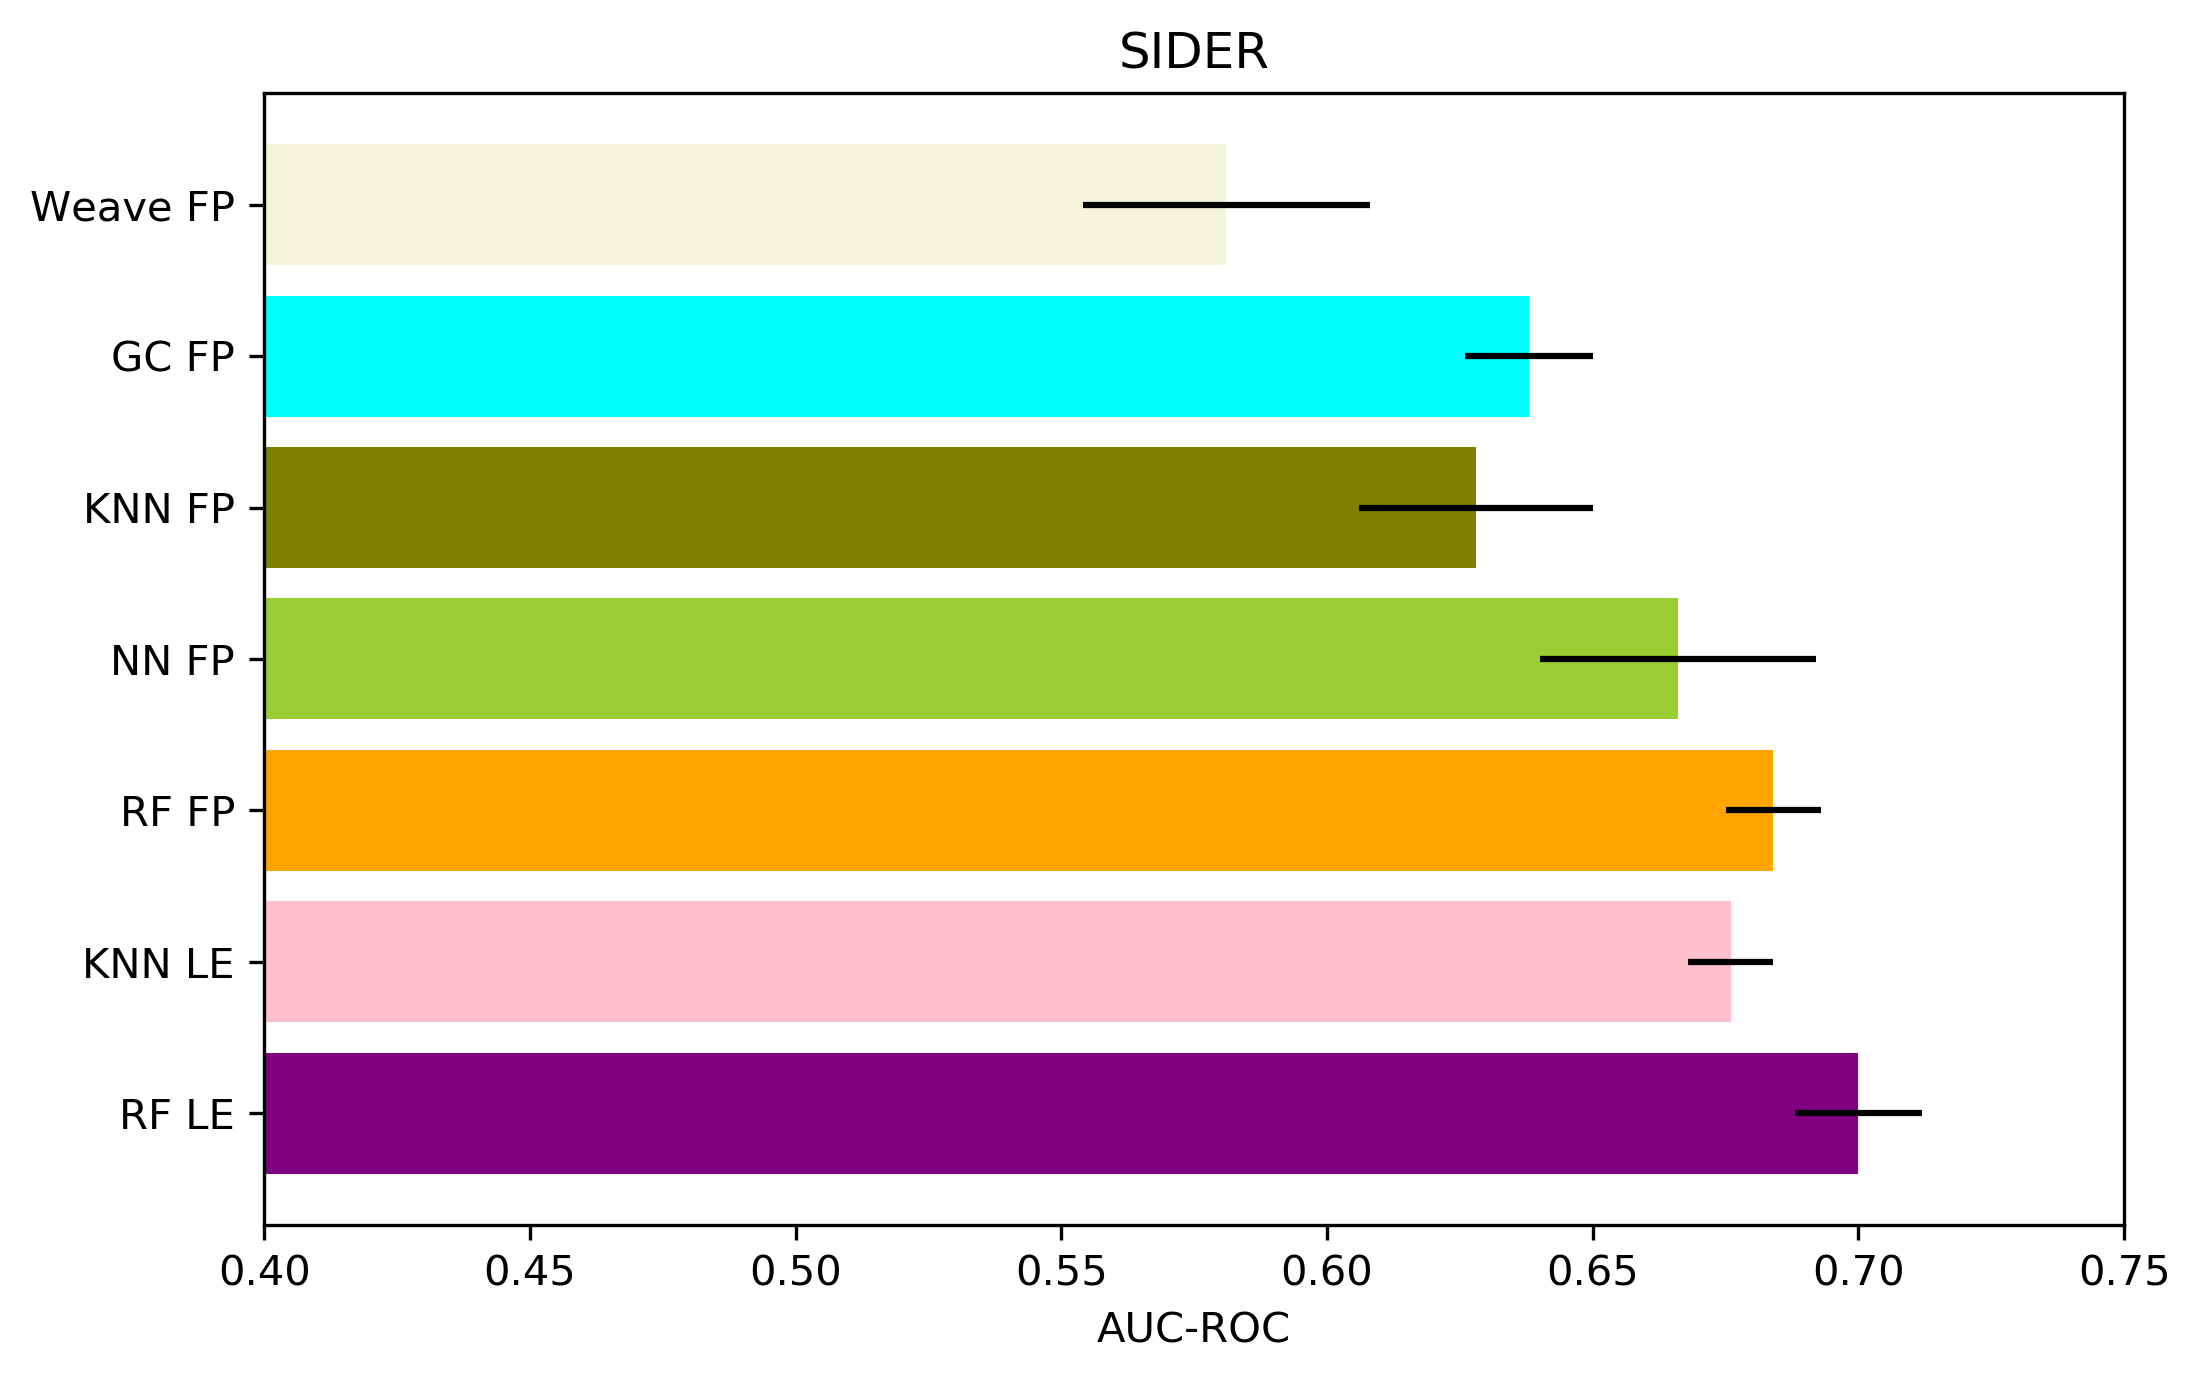

In [21]:
plt.figure(figsize=(8,5), dpi=300)
plt.barh(models, roc_mean, xerr=roc_std, color=colors)
plt.xlim([0.4, 0.75])
plt.xlabel('AUC-ROC')
plt.title('SIDER')
plt.show()